In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"]= (10, 5.5)

# Dati settimanali (con weekend) senza outlier

In [3]:
u1_agg = pd.read_csv("./u1_we_agg.csv")

In [4]:
u1_h = u1_agg.set_index(pd.DatetimeIndex(u1_agg["T"]))

In [5]:
u1_w = u1_h.resample("W").mean()
u1_w_all = u1_w.rename(columns={"CONSUMO_ATTIVA_PRELEVATA": "consumi_original"})
u1_w = u1_w_all[["consumi_original"]]

### Prophet per eliminare outlier

In [6]:
dummy = u1_w.reset_index()
dummy.columns = ["ds","y"]

In [7]:
m = Prophet()
m.fit(dummy)

future = m.make_future_dataframe(periods=10)

forecast = m.predict(future)
forecast[["ds","yhat_lower","yhat_upper"]].head()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat_lower,yhat_upper
0,2018-01-07,65.318717,83.164628
1,2018-01-14,70.596696,88.041123
2,2018-01-21,75.201933,92.919924
3,2018-01-28,76.851633,94.746658
4,2018-02-04,75.079949,93.842469


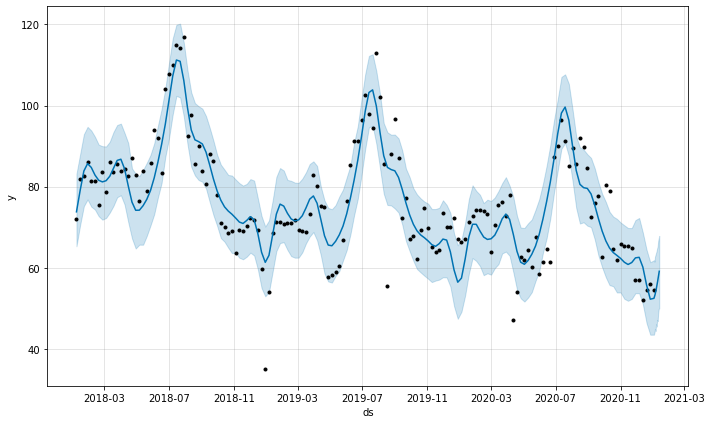

In [8]:
m.plot(forecast);

In [9]:
u1_fix = dummy.merge(forecast[["yhat_lower","yhat_upper","ds"]], on="ds")
u1_fix["consumi"] = np.where(u1_fix["y"] < u1_fix["yhat_lower"], u1_fix["yhat_lower"], u1_fix["y"])

In [10]:
u1_fix = u1_fix.rename(columns={"ds": "T"})
u1_fix = u1_fix.set_index(pd.DatetimeIndex(u1_fix["T"]))
u1_fix = u1_fix.drop(["y","yhat_lower","yhat_upper","T"], axis=1)
u1_fix.tail()

,consumi
T,
2020-12-06,57.027679
2020-12-13,52.162143
2020-12-20,54.510893
2020-12-27,55.963393
2021-01-03,54.566875


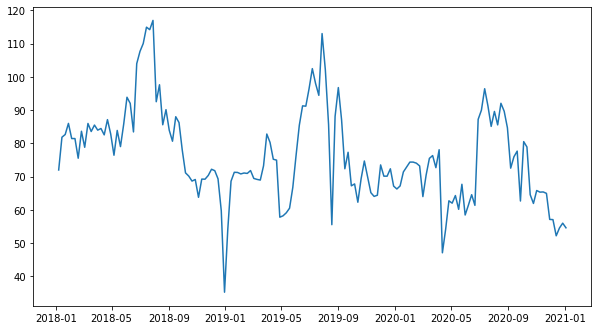

In [11]:
plt.plot(u1_w["consumi_original"])

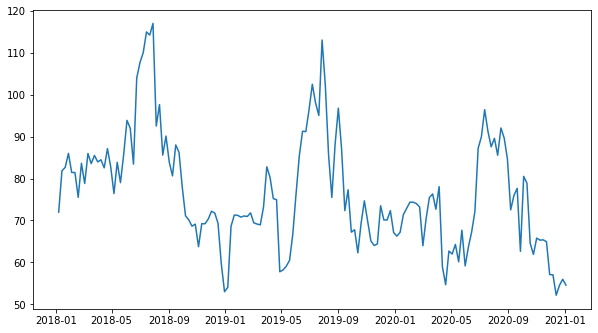

In [12]:
plt.plot(u1_fix["consumi"])

# Final data

In [13]:
u1_new = u1_fix.merge(u1_w_all[["temperature", "humidity", "is_raining", "ore_luce"]], on="T")

In [14]:
u1_new.to_csv("./u1_week_meteo.csv", header=True)
u1_new

,consumi,temperature,humidity,is_raining,ore_luce
T,,,,,
2018-01-07,71.972143,4.996983,86.035516,0.171131,8.000000
2018-01-14,81.837321,6.448011,90.257044,0.201190,8.000000
2018-01-21,82.646071,4.234131,78.665278,0.081548,8.000000
2018-01-28,85.991607,4.921339,85.377083,0.064286,8.434524
2018-02-04,81.431250,4.706734,94.203671,0.072917,9.000000
...,...,...,...,...,...
2020-12-06,57.027679,3.460461,92.447321,0.397024,8.000000
2020-12-13,52.162143,5.004780,97.379762,0.299702,8.000000
2020-12-20,54.510893,6.563409,95.424702,0.160714,8.000000
